# 作業：Transformer 和 RNN-attention 比較
***
## [作業目標]
- 瞭解 Transformer 的表現
- 可視化 Transformer Attention 並掌握其內部結構

# [作業重點]
- Transformer 和 RNN-attention 效果比較
    - 模型效果
    - 訓練速度
    - 模型大小
- 可視化 Transformer Attention 結果並與 RNN-attention 進行比較


In [1]:
import os
import re
import csv
import math
import time
import spacy
import pandas as pd

import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext.data.metrics import bleu_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 進行 matplotlib 繪製中文
# 下載字體
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 自定義字體
myfont = FontProperties(fname='taipei_sans_tc_beta.ttf')
sns.set()

--2021-02-05 16:32:03--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.195.138, 74.125.195.101, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nu1kb3eam8f0la4id9t8p2l70udfj30f/1612542675000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-02-05 16:32:05--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nu1kb3eam8f0la4id9t8p2l70udfj30f/1612542675000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|173.1

## 機器翻譯訓練資料
來源: https://www.manythings.org/anki/

Chinese (Mandarin) - English --> cmn-eng.zip (24360)

解壓檔案並放置於 data 目錄

In [3]:
!wget https://www.manythings.org/anki/cmn-eng.zip
!unzip cmn-eng.zip -d data

--2021-02-05 16:32:06--  https://www.manythings.org/anki/cmn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.55.222, 172.67.173.198, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.55.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1062383 (1.0M) [application/zip]
Saving to: ‘cmn-eng.zip’

cmn-eng.zip         100%[===================>]   1.01M  2.35MB/s    in 0.4s    

2021-02-05 16:32:07 (2.35 MB/s) - ‘cmn-eng.zip’ saved [1062383/1062383]

Archive:  cmn-eng.zip
  inflating: data/cmn.txt            
  inflating: data/_about.txt         


In [4]:
data_dir = 'data'
with open(os.path.join(data_dir, 'cmn.txt'), encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
    trnslt_pairs = [l.split('\t') for l in lines]

print(f"Sample: {trnslt_pairs[1000][0:2]}")
print(f"Total records: {len(trnslt_pairs)}")

Sample: ['He was drowned.', '他被淹死了。']
Total records: 24360


## 將資料切分成 train/valiation/test 三個資料集，且以 csv 格式儲存在 data 目錄

In [5]:
train, test = train_test_split(trnslt_pairs, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(f"training data: {len(train)} , validation data: {len(val)} , testing data: {len(test)}")

def write_csv(data, file_path):
    with open(file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for item in data:
            writer.writerow([item[0], item[1]])

write_csv(train, os.path.join(data_dir, 'train.csv'))
write_csv(val, os.path.join(data_dir, 'val.csv'))
write_csv(test, os.path.join(data_dir, 'test.csv'))

training data: 19731 , validation data: 2193 , testing data: 2436


## 下載 spacy 英文/中文語料

In [6]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("zh_core_web_sm")

import en_core_web_sm, zh_core_web_sm
spacy_en, spacy_zh = en_core_web_sm.load(), zh_core_web_sm.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')


## 使用 torchtext 來準備訓練資料

In [7]:
def tokenize_zh(text):
    # 移除非中文字元
    text = re.sub(r'[^\u4e00-\u9fa5A-Za-z0-9]', '', text)

    return [word.text for word in spacy_zh.tokenizer(text)]

def tokenize_en(text):
    # 清除不需要的字元
    text = re.sub(r'([.!?])', r' \1', text)

    return [tok.text for tok in spacy_en.tokenizer(text)]

TRG = Field(tokenize=tokenize_en, init_token='<sos>',
            eos_token='<eos>', lower=True, batch_first=True)
SRC = Field(tokenize=tokenize_zh, init_token='<sos>',
            eos_token='<eos>', lower=True, batch_first=True)

## 使用 TabularDataset 讀資料並建立辭典

In [8]:
train_dataset, dev_dataset, test_dataset = TabularDataset.splits(
    path=data_dir, format='csv', skip_header=True,
    train='train.csv', validation='val.csv', test='test.csv',
    fields=[('trg', TRG), ('src', SRC)]
)
SRC.build_vocab(train_dataset, min_freq=1)
TRG.build_vocab(train_dataset, min_freq=1)
print(f"中文語料辭典大小: {len(SRC.vocab)}, 英文辭典大小: {len(TRG.vocab)}")
print(f"Sample SRC: {test_dataset[0].src}, TRG: {test_dataset[0].trg}")

中文語料辭典大小: 12321, 英文辭典大小: 6098
Sample SRC: ['有人', '說', '中', '國像', '是', '俄國', '的', '殖民地'], TRG: ['some', 'say', 'that', 'china', 'was', 'like', 'a', 'russian', 'colony', '.']


In [9]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, dev_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

## Transformer Model

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_enc_layers, n_attn_heads,
                 dropout, src_voca_length, max_pos_length, device):
        super(TransformerEncoder, self).__init__()
        self.device = device
        self.src_tok_embedding = nn.Embedding(src_voca_length, hidden_dim)
        self.src_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)
        self.transformer_encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(
                hidden_dim, feedforward_dim, n_enc_layers, n_attn_heads, dropout, device
            ) for _ in range(n_enc_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src_sentence, src_mask):
        batch_size = src_sentence.shape[0]
        src_len = src_sentence.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        src_sentence = self.dropout(
            self.src_tok_embedding(src_sentence) + self.src_pos_embedding(pos)
        )
        for layer in self.transformer_encoder_layers:
            src_sentence , encoder_self_attention = layer(src_sentence, src_mask)

        return src_sentence, encoder_self_attention

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim , feedforward_dim, n_enc_layers, n_attn_heads, dropout, device):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim,
                                                                  n_attn_heads,
                                                                  dropout,device)
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
        self.feedforward_sublayer = PosFeedForwardSubLayer(hidden_dim, feedforward_dim, dropout)
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src_embedding, src_mask):
        _src, encoder_self_attention = self.self_attention_sublayer(
            src_embedding, src_embedding, src_embedding, src_mask
        )
        src_embedding = self.self_attn_layernorm(src_embedding + self.dropout(_src))
        _src = self.feedforward_sublayer(src_embedding)
        src_embedding = self.feedforward_layernorm(src_embedding + self.dropout(_src))

        return src_embedding , encoder_self_attention

class MultiHeadAttentionSubLayer(nn.Module):
    def __init__(self, hidden_dim , n_attn_heads, dropout, device):
        super(MultiHeadAttentionSubLayer, self).__init__()
        assert hidden_dim % n_attn_heads ==0
        self.hidden_dim = hidden_dim
        self.n_attn_heads = n_attn_heads
        self.head_dim = hidden_dim // n_attn_heads
        self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)
        self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query_input, key_input, value_input, mask=None):
        batch_size = query_input.shape[0]
        Q = self.full_conn_q(query_input)
        K = self.full_conn_k(key_input)
        V = self.full_conn_v(value_input)

        def split_attention(Q, K, V):
            Q = Q.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            K = K.view(batch_size, -1, self.n_attn_heads, self.head_dim)
            V = V.view(batch_size, -1, self.n_attn_heads, self.head_dim)

            return Q , K , V

        def seperate_heads(Q, K, V):
            Q = Q.permute(0, 2, 1, 3)  # (batch_size, n_heads , query_len , head_dim)
            K = K.permute(0, 2, 1, 3)  # (batch_size, n_heads , key_len , head_dim)
            V = V.permute(0, 2, 1, 3)  # (batch_size, n_heads , value_len , head_dim)

            return Q , K , V

        Q, K, V = split_attention(Q, K, V)
        Q, K, V = seperate_heads(Q, K, V)
        scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        if mask is not None:
            scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask == 0,
                                                                                      -1e10)

        attention = torch.softmax(scaled_dot_product_similarity, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hidden_dim)
        x = self.full_conn_o(x)

        return x, attention

class PosFeedForwardSubLayer(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout):
        super(PosFeedForwardSubLayer, self).__init__()
        self.full_conn_1 = nn.Linear(hidden_dim, ff_dim)
        self.full_conn_2 = nn.Linear(ff_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(torch.relu(self.full_conn_1(x)))
        x = self.full_conn_2(x)

        return x

class TransformerDecoder(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout,
                 dec_voca_length, max_pos_length, device , skip_encoder_attn=False):
        super(TransformerDecoder, self).__init__()
        self.device = device
        self.dec_tok_embedding = nn.Embedding(dec_voca_length, hidden_dim)
        self.dec_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)
        self.transformer_decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(
                hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads,
                dropout, device, skip_encoder_attn
            ) for _ in range(n_dec_layers)
        ])
        self.full_conn_out = nn.Linear(hidden_dim, dec_voca_length)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, dec_seq, enc_hidden, dec_mask, enc_mask):
        batch_size = dec_seq.shape[0]
        dec_len = dec_seq.shape[1]
        pos = torch.arange(0, dec_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        dec_seq = self.dropout(self.dec_tok_embedding(dec_seq) + self.dec_pos_embedding(pos))
        for layer in self.transformer_decoder_layers:
            dec_seq, encoder_decoder_attention , decoder_self_attention = layer(
                dec_seq, enc_hidden, dec_mask, enc_mask
            )
        output = self.full_conn_out(dec_seq)

        return output, encoder_decoder_attention, decoder_self_attention

class TransformerDecoderLayer(nn.Module):
    def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads,
                 dropout, device, skip_encoder_attn=False):
        super(TransformerDecoderLayer, self).__init__()
        self.skip_encoder_attn = skip_encoder_attn
        self.self_attention_sublayer = MultiHeadAttentionSubLayer(
            hidden_dim, n_attn_heads, dropout, device
        )
        self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
        if not skip_encoder_attn:
            self.encoder_attention_sublayer = MultiHeadAttentionSubLayer(
                hidden_dim, n_attn_heads, dropout, device
            )
            self.encoder_attn_layernorm = nn.LayerNorm(hidden_dim)
        self.positionwise_feedforward = PosFeedForwardSubLayer(hidden_dim,
                                                               feedforward_dim,
                                                               dropout)
        self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, dec_seq, enc_hidden, dec_mask, enc_mask):
        _dec_seq, decoder_self_attention = self.self_attention_sublayer(
            dec_seq, dec_seq, dec_seq, dec_mask
        )
        dec_seq = self.self_attn_layernorm(dec_seq + self.dropout(_dec_seq))

        if not self.skip_encoder_attn:
            _dec_seq, encoder_decoder_attention = self.encoder_attention_sublayer(
                dec_seq, enc_hidden, enc_hidden, enc_mask
            )
            dec_seq = self.encoder_attn_layernorm(dec_seq + self.dropout(_dec_seq))
        else:
            encoder_decoder_attention = None

        _dec_seq = self.positionwise_feedforward(dec_seq)
        dec_seq = self.feedforward_layernorm(dec_seq + self.dropout(_dec_seq))

        return dec_seq, encoder_decoder_attention , decoder_self_attention

class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src, encoder_self_attention = self.encoder(src, src_mask)
        output, encoder_decoder_attention, decoder_self_attention = self.decoder(
            trg, enc_src, trg_mask, src_mask
        )

        return output, encoder_decoder_attention, encoder_self_attention, decoder_self_attention

## 建立模型和重要參數

In [11]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
MAX_SENT_LENGTH = 40
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_FF_DIM = 512
DEC_FF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
LEARNING_RATE = 0.0005

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


enc = TransformerEncoder(
    HID_DIM, ENC_FF_DIM, ENC_LAYERS, ENC_HEADS, ENC_DROPOUT, INPUT_DIM, MAX_SENT_LENGTH, device
)
dec = TransformerDecoder(
    HID_DIM, DEC_FF_DIM, DEC_LAYERS, DEC_HEADS, DEC_DROPOUT, OUTPUT_DIM, MAX_SENT_LENGTH, device
)
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)
print(f"Total parameters of model "
      f"{sum(p.numel() for p in model.parameters() if p.requires_grad):0.0f}")
model

Total parameters of model 10256594


Transformer(
  (encoder): TransformerEncoder(
    (src_tok_embedding): Embedding(12321, 256)
    (src_pos_embedding): Embedding(40, 256)
    (transformer_encoder_layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attention_sublayer): MultiHeadAttentionSubLayer(
          (full_conn_q): Linear(in_features=256, out_features=256, bias=True)
          (full_conn_k): Linear(in_features=256, out_features=256, bias=True)
          (full_conn_v): Linear(in_features=256, out_features=256, bias=True)
          (full_conn_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (self_attn_layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (feedforward_sublayer): PosFeedForwardSubLayer(
          (full_conn_1): Linear(in_features=256, out_features=512, bias=True)
          (full_conn_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=Fals

## train and evalutate functions

In [12]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    epoch_loss = 0
    for batch in iterator:
        src, trg = batch.src, batch.trg

        # (batch_size, trg_len - 1, output_dim)
        output, _ , _ , _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]

        # (batch_size * (trg len - 1), output_dim)
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)  # (batch_size * (trg len - 1))

        loss = criterion(output, trg)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src, trg = batch.src, batch.trg

            # (batch_size, trg_len - 1, output_dim)
            output, _ , _ , _ = model(src, trg[:, :-1])
            output_dim = output.shape[-1]

            # (batch_size * (trg len - 1), output_dim)
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)  # (batch_size * (trg len - 1))

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

## 訓練設定

In [13]:
MAX_EPOCHS = 20
CLIP = 5
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

best_valid_loss = 9999999
for epoch in range(MAX_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()

    torch.save(model.state_dict(), os.path.join(model_dir, f"model-{epoch}.pt"))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best-model.pt'))

    print(f"Epoch {epoch:2d} training time: {end_time - start_time:.2f} sec, "
          f"Training Loss: {train_loss:.3f}, Valiation Loss: {valid_loss:.3f}")

Epoch  0 training time: 7.69 sec, Training Loss: 5.343, Valiation Loss: 4.643
Epoch  1 training time: 7.78 sec, Training Loss: 4.299, Valiation Loss: 4.020
Epoch  2 training time: 7.74 sec, Training Loss: 3.777, Valiation Loss: 3.671
Epoch  3 training time: 7.78 sec, Training Loss: 3.447, Valiation Loss: 3.438
Epoch  4 training time: 7.71 sec, Training Loss: 3.187, Valiation Loss: 3.349
Epoch  5 training time: 7.66 sec, Training Loss: 2.977, Valiation Loss: 3.193
Epoch  6 training time: 7.60 sec, Training Loss: 2.739, Valiation Loss: 3.031
Epoch  7 training time: 7.54 sec, Training Loss: 2.502, Valiation Loss: 2.930
Epoch  8 training time: 7.56 sec, Training Loss: 2.283, Valiation Loss: 2.844
Epoch  9 training time: 7.59 sec, Training Loss: 2.052, Valiation Loss: 2.742
Epoch 10 training time: 7.66 sec, Training Loss: 1.827, Valiation Loss: 2.717
Epoch 11 training time: 7.52 sec, Training Loss: 1.648, Valiation Loss: 2.598
Epoch 12 training time: 7.57 sec, Training Loss: 1.407, Valiatio

## Evaluate testing set

In [14]:
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f} |')

| Test Loss: 2.608 | Test PPL: 13.577 |


In [15]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src, encoder_self_attention = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, encoder_decoder_attention , decoder_self_attention = model.decoder(
                trg_tensor, enc_src, trg_mask, src_mask
            )

        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], encoder_decoder_attention,\
           encoder_self_attention, decoder_self_attention

## BLEU score evaluation

In [16]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs, pred_trgs = [], []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ , _, _ = translate_sentence(
            src, src_field, trg_field, model, device, max_len
        )

        # cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [17]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score * 100:.2f}')

BLEU score = 24.04


## display attention of Transfomer functions
- plot_sum_attention --> 視覺化 Attention 權重平均
- plot_multi_attention --> 視覺化每個 Attention Head 權重

In [18]:
def plot_attention(sentence, translation, attention):
    weights = attention.squeeze(0).mean(axis=0).cpu().numpy()
    df = pd.DataFrame(data=weights, index=translation, columns=sentence)
    fig, ax = plt.subplots(figsize=(8, 8))

    plt.tick_params(axis='both', which='major', labelsize=10, 
                    labelbottom=False, bottom=False, top=False, labeltop=True)
    sns.heatmap(df, vmin=0, vmax=1.0, ax=ax, cmap='Blues', cbar=False)
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=360, ha='right', fontproperties=myfont)
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=90, ha='right', fontproperties=myfont)
    plt.show()

def plot_multi_attention(sentence, translation, attention, n_rows=4, n_cols=2):
    attention = attention.squeeze(0)
    n_heads = attention.size(0)
    assert n_rows * n_cols >= n_heads
    fig = plt.figure(figsize=(8 * n_cols, 8 * n_rows))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        weights = attention[i].cpu().numpy()
        df = pd.DataFrame(data=weights, index=translation, columns=sentence)
        plt.tick_params(axis='both', which='major', labelsize=10, 
                        labelbottom=False, bottom=False, top=False, labeltop=True)
        sns.heatmap(df, vmin=0, vmax=1.0, ax=ax, cmap='Blues', cbar=False)
        label_y = ax.get_yticklabels()
        plt.setp(label_y, rotation=360, ha='right', fontproperties=myfont)
        label_x = ax.get_xticklabels()
        plt.setp(label_x, rotation=90, ha='right', fontproperties=myfont)
    plt.show()


## 觀察翻譯結果

In [19]:
# 請在這自行調整 sample index 觀察不同句子結果
example_idx = 123

src = vars(train_dataset.examples[example_idx])['src']
print(f'src = {src}')
trg = vars(train_dataset.examples[example_idx])['trg']
print(f'trg = {trg}')

translation, encoder_decoder_attention, encoder_self_attention, decoder_self_attention = translate_sentence(
    src, SRC, TRG, model, device
)
print(f"predicted trg = {translation}")

src = ['我', '媽媽', '的', '廚藝', '很', '好']
trg = ['my', 'mother', 'is', 'a', 'very', 'good', 'cook', '.']
predicted trg = ['my', 'mother', 'is', 'a', 'good', 'cook', '.', '<eos>']


## 繪製 encoder and decoder attention (one)
這裡把所有的 attention heads 取平均呈現

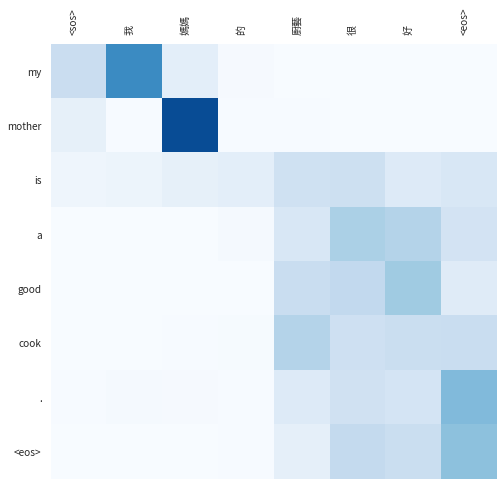

In [20]:
plot_attention(['<sos>'] + src + ['<eos>'], translation, encoder_decoder_attention)

## 繪製 encoder and decoder attention (many)
分別呈現各個 attention heads 的結果

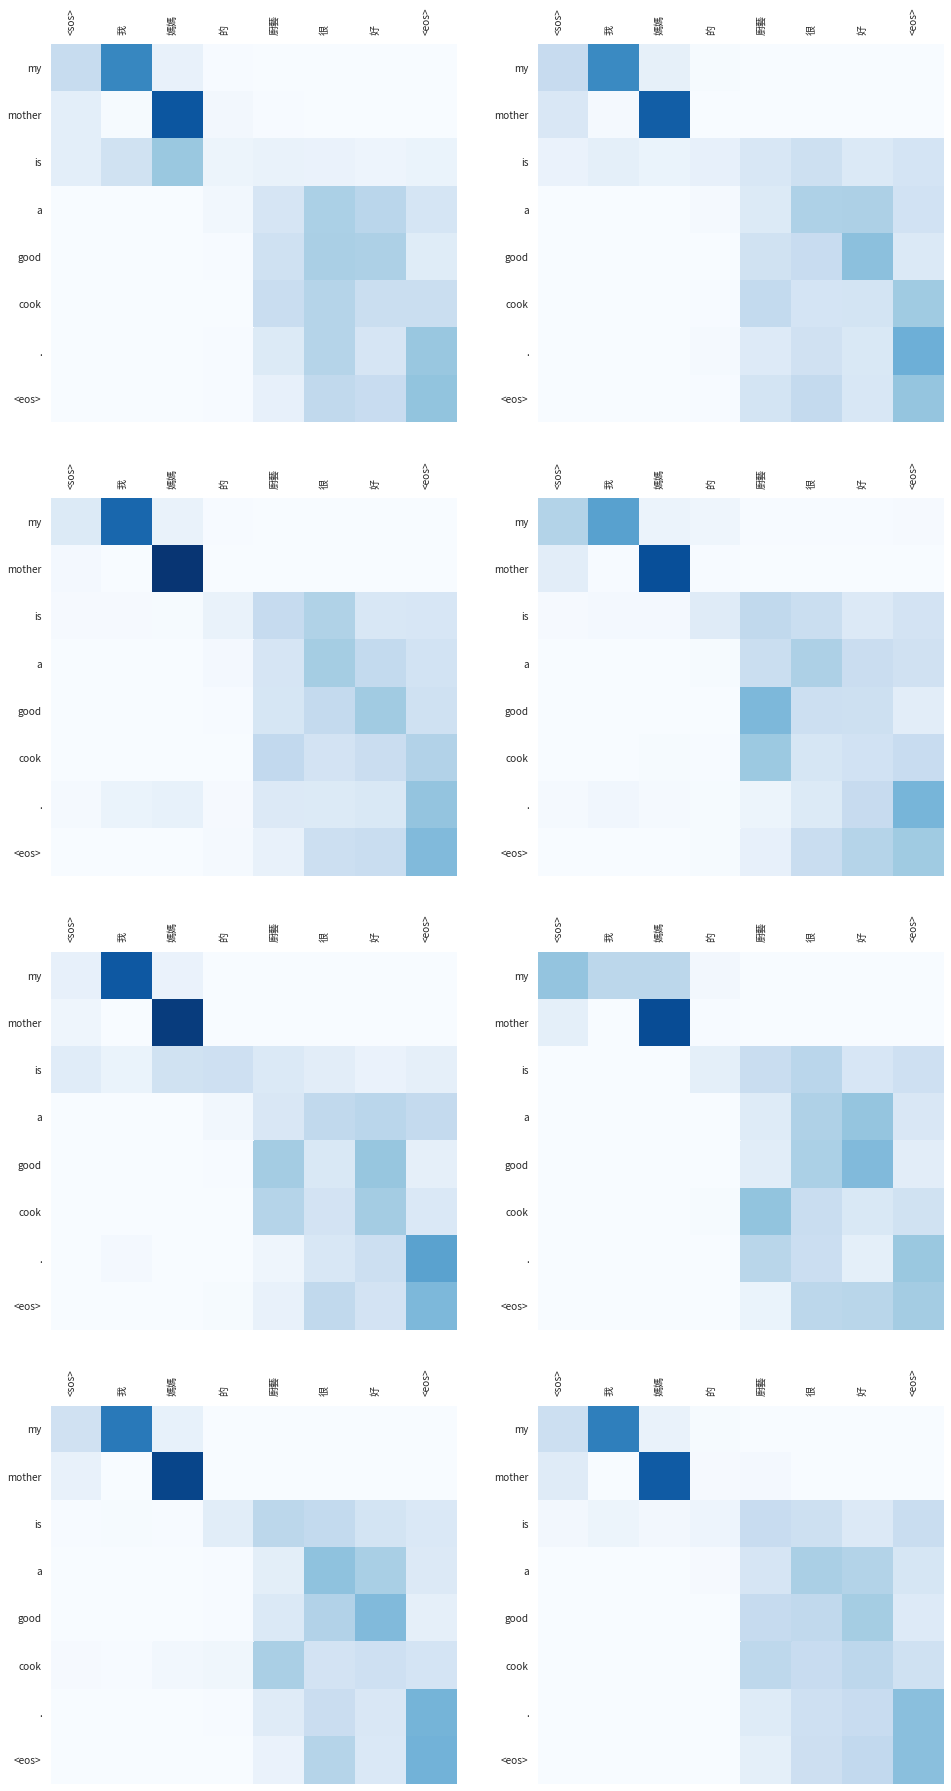

In [21]:
plot_multi_attention(['<sos>'] + src + ['<eos>'], translation, encoder_decoder_attention)

## 繪製 encoder self attention (one)
這裡把所有的 attention heads 取平均呈現

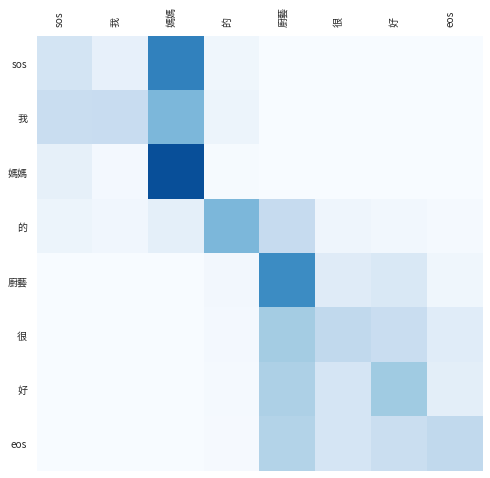

In [22]:
plot_attention(['sos'] + src + ['eos'], ['sos'] + src + ['eos'], encoder_self_attention)

## 繪製 encoder self attention (many)
分別呈現各個 attention heads 的結果

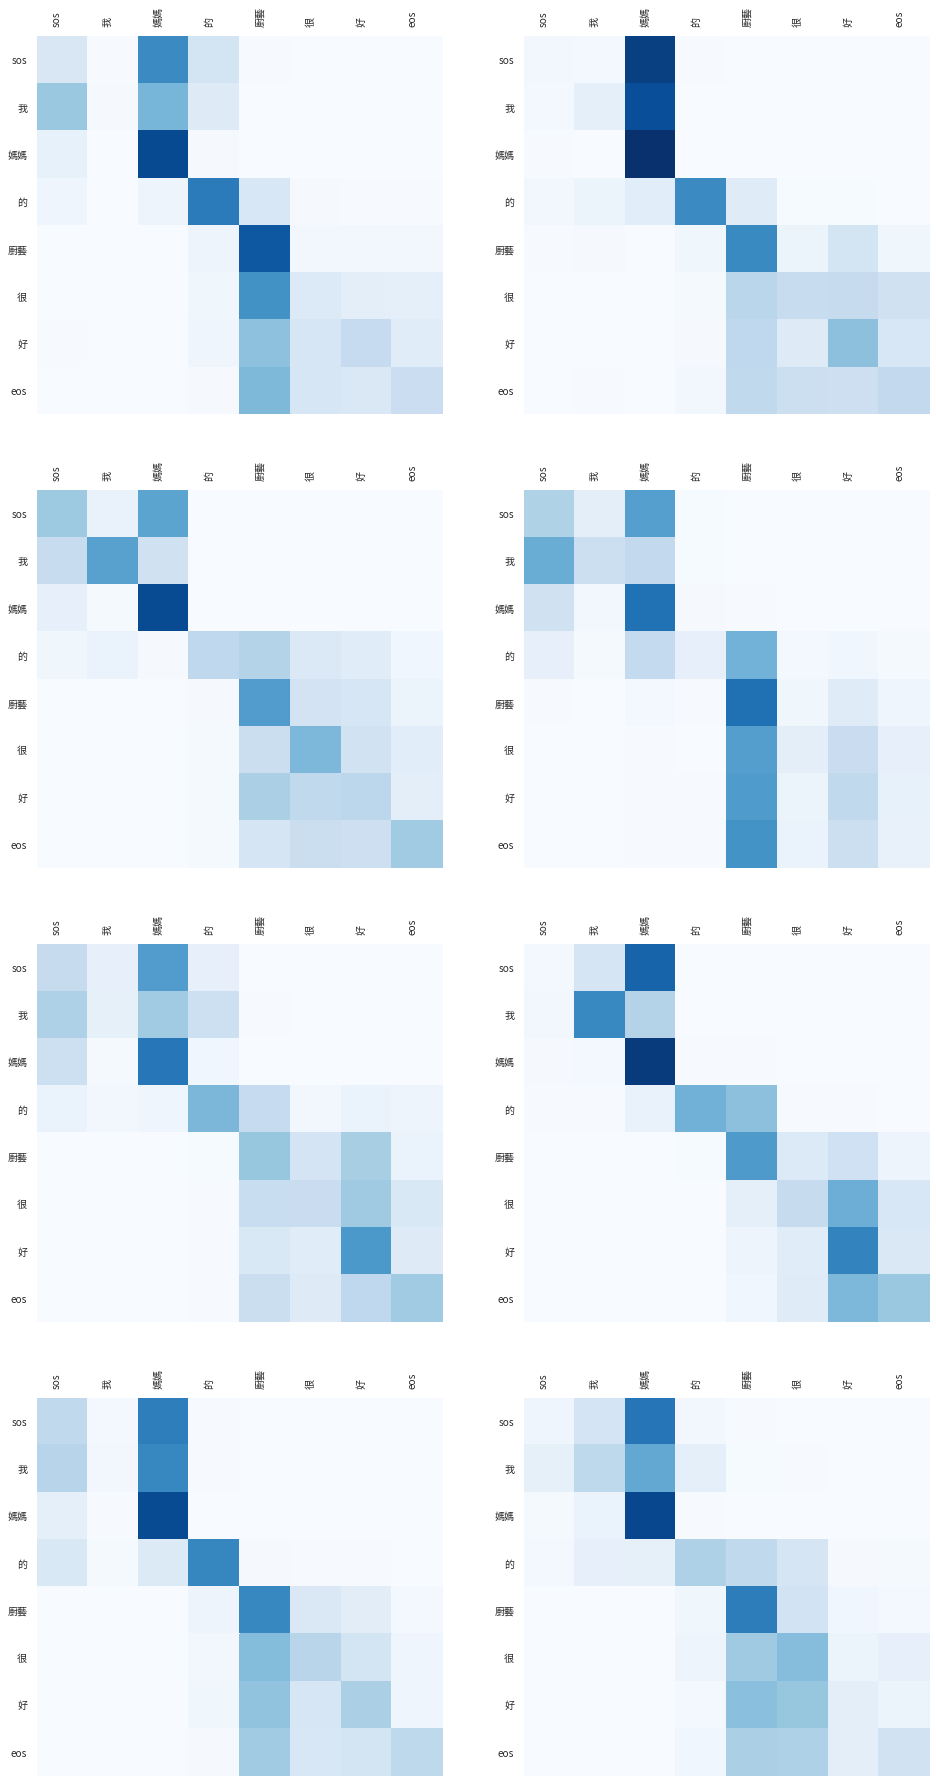

In [23]:
plot_multi_attention(['sos'] + src + ['eos'], ['sos'] + src + ['eos'], encoder_self_attention)

## 繪製 decoder self attention (one)
這裡把所有的 attention heads 取平均呈現

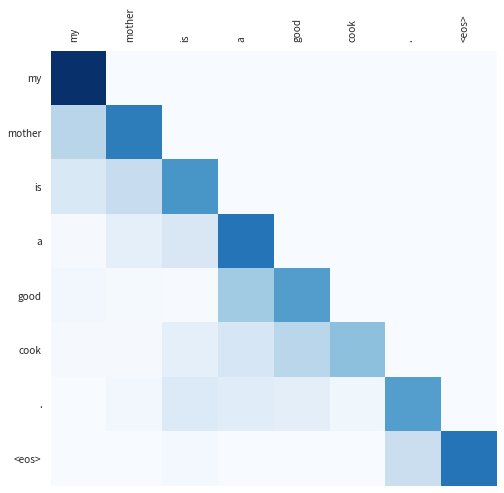

In [24]:
plot_attention(translation, translation, decoder_self_attention)

## 繪製 decoder self attention (many)
分別呈現各個 attention heads 的結果

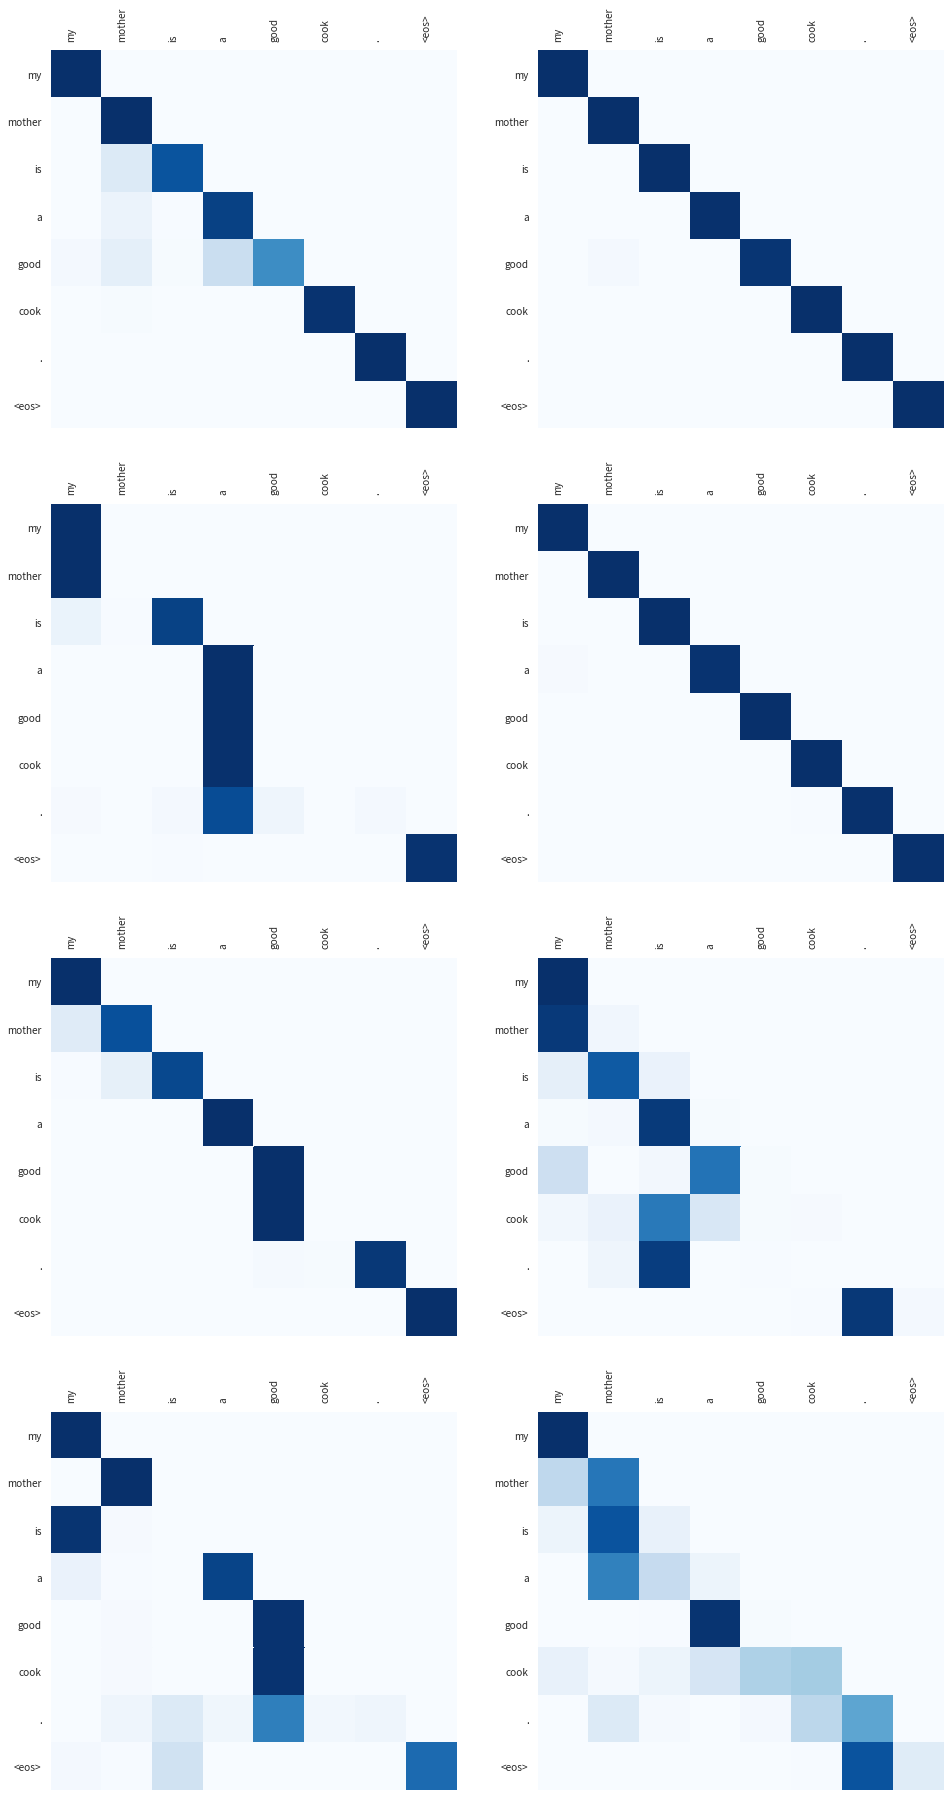

In [25]:
plot_multi_attention(translation, translation, decoder_self_attention)